# Simple analysis on Spectrum Scale policy list scans

This is a simple example on how to quickly dig into SpectrumScale policy lists. In the current example, we ran a scan with the following policy (rule courtesy of Alvise Dorigo):

```
RULE 'listall' list 'all-files'  

SHOW( varchar(kb_allocated) || ' * ' || varchar(file_size) || ' * ' || varchar(user_id) || ' * ' || fileset_name || ' * ' || varchar(creation_time) )

WHERE MODIFICATION_TIME > '2018-01-01 00:00:00' AND ( PATH_NAME LIKE '/gpfs/photonics/swissfel/raw%' )

```

The idea is to load data into a Pandas dataframe and do some analysis. First, the usual imports:

In [2]:
% matplotlib nbagg
import pandas as pd
import matplotlib.pyplot as plt

Then, we load the Spectrum Scale file. Pandas can read compressed and uncompressed data, so we keep the bzipped file.

For each scan, Spectrum Scale always adds inode number, generation number, a "--" separator and the file name. There rest is dependend on your policy: in this case, we have few fields, separated by *

In [4]:
f = "/home/sala/Work/Data/SwissFEL/Storage/list.all-files.bz2"

headers = ["Inode number", "gen number", "Snapshot ID", ]
headers += ["kb_allocated", "sep1", "filesize", "sep2", "user_id", "sep3", "fileset_name", "sep4", "creation_date", "creation_time"]
headers += ["Seperator", "Filename"]

df = pd.read_csv(f, sep=r"\s+", names=headers, )


This is how the dataframe looks like:

In [5]:
df.head()

,Inode number,gen number,Snapshot ID,kb_allocated,sep1,filesize,sep2,user_id,sep3,fileset_name,sep4,creation_date,creation_time,Seperator,Filename
0,131072,479551462,0,1792,*,1687617,*,0,*,root,*,2018-04-20,10:26:58.475959,--,/gpfs/photonics/swissfel/raw/md5_20180420.txt
1,342016,1744075055,0,1792,*,1687565,*,0,*,root,*,2018-04-18,09:33:40.578490,--,/gpfs/photonics/swissfel/raw/md5.txt
2,1054720,302718518,0,256,*,42980,*,0,*,alvra-cache-staff,*,2018-04-10,13:12:14.108445,--,/gpfs/photonics/swissfel/raw/alvra-staff/md5.txt
3,1054721,1760521522,0,256,*,7107,*,0,*,alvra-cache-staff,*,2018-06-12,16:03:37.555993,--,/gpfs/photonics/swissfel/raw/alvra-staff/p1658...
4,1067008,783981730,0,4608768,*,4719258528,*,16583,*,alvra-cache-staff,*,2018-04-30,14:58:12.572246,--,/gpfs/photonics/swissfel/raw/alvra-staff/p1658...


Date and time are separated. So, first me merge them, then we convert them to Pandas datetime, and we use them as index. The output is nice:

In [6]:
df["date"] = df["creation_date"] + " " + df["creation_time"]
df["date"] = pd.to_datetime(df["date"])
df2 = df.set_index("date")
df2.sort_index(inplace=True)
df2.head()

,Inode number,gen number,Snapshot ID,kb_allocated,sep1,filesize,sep2,user_id,sep3,fileset_name,sep4,creation_date,creation_time,Seperator,Filename
date,,,,,,,,,,,,,,,
2018-02-06 10:54:32.961646,1137259,1993859079,0,4636160,*,4747207527,*,16581,*,alvra-cache-staff,*,2018-02-06,10:54:32.961646,--,/gpfs/photonics/swissfel/raw/alvra-staff/p1658...
2018-02-06 13:51:07.037572,1137048,891254881,0,4562432,*,4671705823,*,16581,*,alvra-cache-staff,*,2018-02-06,13:51:07.037572,--,/gpfs/photonics/swissfel/raw/alvra-staff/p1658...
2018-02-06 13:53:48.105365,1137244,496329671,0,4203008,*,4303631880,*,16581,*,alvra-cache-staff,*,2018-02-06,13:53:48.105365,--,/gpfs/photonics/swissfel/raw/alvra-staff/p1658...
2018-02-22 14:32:45.262411,2179441,1984203770,0,4352,*,4206280,*,16582,*,bernina-cache-staff,*,2018-02-22,14:32:45.262411,--,/gpfs/photonics/swissfel/raw/bernina-staff/p16...
2018-02-22 15:09:19.292093,2179168,1050995437,0,409856,*,419482756,*,16582,*,bernina-cache-staff,*,2018-02-22,15:09:19.292093,--,/gpfs/photonics/swissfel/raw/bernina-staff/p16...


Time to plot. We select the file set n

<IPython.core.display.Javascript object>


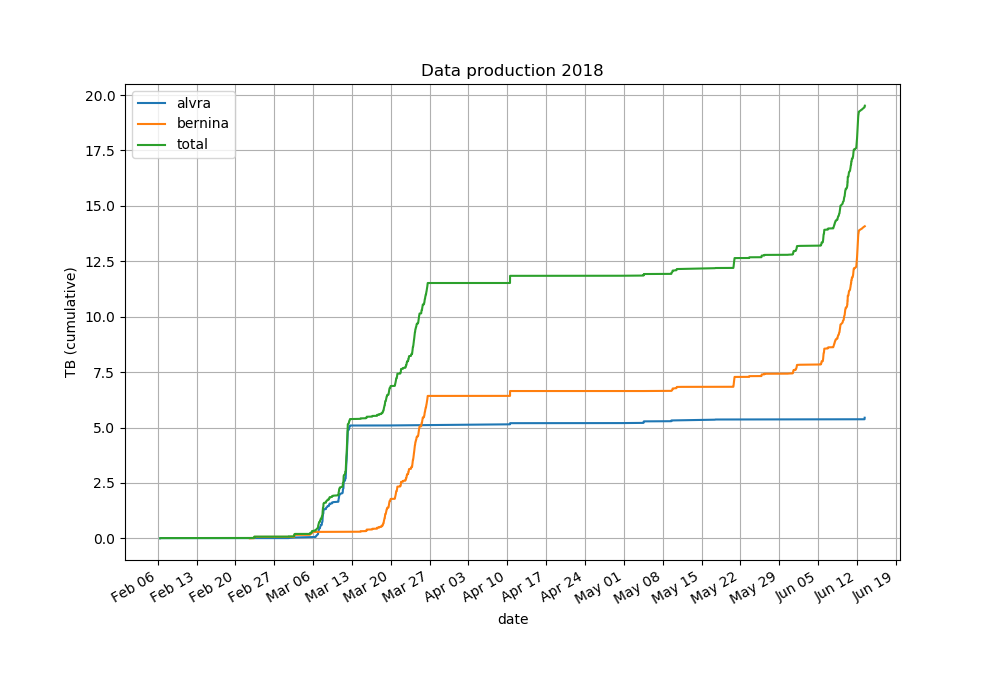

In [8]:
import matplotlib.dates as mdates



fig, ax = plt.subplots(figsize=(10,7))

(df2[df2["fileset_name"] == "alvra-cache-staff"]["kb_allocated"] / (1024**3)).cumsum().plot(ax=ax, label="alvra")
(df2[df2["fileset_name"] == "bernina-cache-staff"]["kb_allocated"] / (1024**3)).cumsum().plot(ax=ax, label="bernina")
(df2["kb_allocated"] / (1024**3)).cumsum().plot(ax=ax, label="total")
plt.legend(loc="best")
plt.grid()
ax.set_ylabel("TB (cumulative)")
ax.set_title("Data production 2018")

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))